/var/folders/nq/d8rg086n21lcvj8v0tdfdzbh0000gn/T/ipykernel_99162/272582585.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start=start, end=end, progress=False)


Downloaded 2889 rows from yfinance, range 2018-01-01 to 2025-11-28

--- Position Signal Value Counts (Should see 1s and -1s) ---
(position, )
 0    2827
 1      31
-1      31
Name: count, dtype: int64
----------------------------------------
Final portfolio value: 11114.396181048822

--- Performance Metrics ---
CAGR           : 0.0137
Sharpe         : 0.2674
Max Drawdown   : -0.0899
Win Rate       : 0.0359


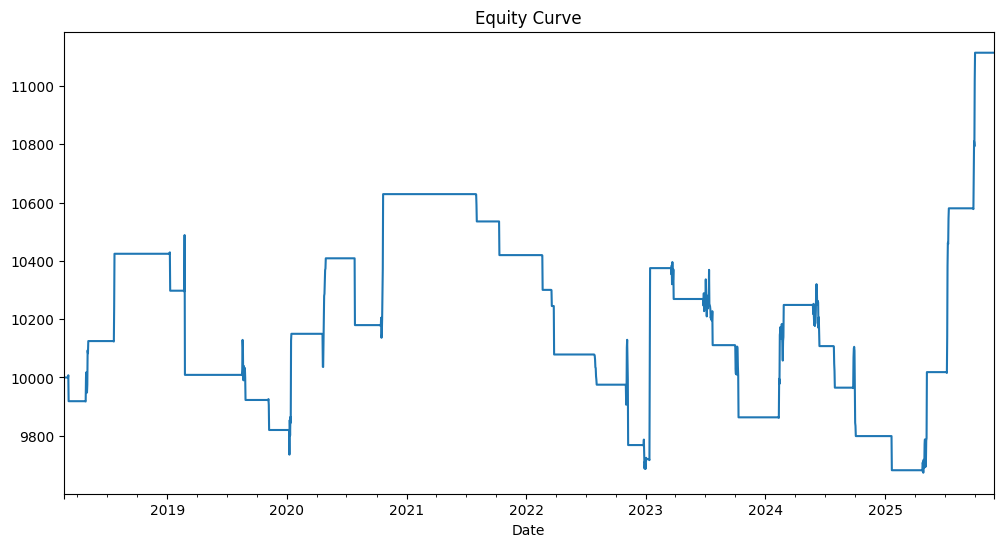

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# --- 1. Data Fetching ---
def fetch_btc_history(start='2018-01-01', end=None):
    """Fetches BTC-USD price data from yfinance."""
    end = end or datetime.now().strftime('%Y-%m-%d')
    try:
        df = yf.download('BTC-USD', start=start, end=end, progress=False)
        if df.empty:
            raise RuntimeError('yfinance returned empty dataframe')
        df = df[['Open','High','Low','Close','Volume']].copy()
        df.index = pd.to_datetime(df.index)
        print(f"Downloaded {len(df)} rows from yfinance, range {df.index[0].date()} to {df.index[-1].date()}")
        return df
    except Exception as e:
        print('yfinance fetch failed:', e)
        # Simplified error handling for this context
        raise RuntimeError('No data available.') from e

# --- 2. Indicator Calculation ---
def add_indicators(df, short_window=20, long_window=50, atr_window=14, rsi_window=14):
    """Calculates SMA, ATR, and RSI. Preserves MultiIndex structure."""
    df = df.copy()

    # Access the primary 'Close' column using the MultiIndex tuple ('Close', 'BTC-USD')
    close_price = df[('Close', 'BTC-USD')]
    high_price = df[('High', 'BTC-USD')]
    low_price = df[('Low', 'BTC-USD')]

    # Calculate SMAs
    df[('SMA_short', '')] = close_price.rolling(short_window).mean()
    df[('SMA_long', '')] = close_price.rolling(long_window).mean()

    # Calculate ATR
    high_low = high_price - low_price
    high_close = (high_price - close_price.shift()).abs()
    low_close = (low_price - close_price.shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df[('ATR', '')] = tr.rolling(atr_window).mean()

    # Calculate RSI (RSI is not used in this strategy but is included in the backtest logic)
    delta = close_price.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(rsi_window).mean()
    ma_down = down.rolling(rsi_window).mean()
    rs = ma_up / (ma_down + 1e-9)
    df[('RSI', '')] = 100 - (100 / (1 + rs))

    return df

# --- 3. Signal Generation ---
def generate_signals(df):
    """Generates the position column based on SMA crossover."""
    df = df.copy()
    
    # Access SMA columns using MultiIndex keys
    sma_short = df[('SMA_short', '')]
    sma_long = df[('SMA_long', '')]

    # Signal is 1 (long) when SMA_short > SMA_long, 0 otherwise
    df[('signal', '')] = np.where(sma_short > sma_long, 1, 0)
    
    # Calculate previous signal for detecting crosses
    df[('signal_prev', '')] = df[('signal', '')].shift(1).fillna(0).astype(int)
    
    # Position: 1 (Buy/Enter) when signal flips 0 -> 1. -1 (Sell/Exit) when signal flips 1 -> 0.
    df[('position', '')] = df[('signal', '')] - df[('signal_prev', '')]
    
    return df

# --- 4. Vectorized Backtester (With MultiIndex Fixes) ---
def backtest_vectorized(df, initial_capital=10000, fee=0.0, sl_pct=None, tp_pct=None, position_sizing='full', atr_multiplier=None):
    
    # IMPORTANT: Ensure all required columns are accessed using their full tuple keys
    required_cols = [
        ('Close', 'BTC-USD'), ('SMA_short', ''), ('SMA_long', ''), 
        ('position', ''), ('High', 'BTC-USD'), ('Low', 'BTC-USD')
    ]
    if atr_multiplier is not None:
        required_cols.append(('ATR', '')) 
        
    df = df.copy().dropna(subset=required_cols)
    
    capital = initial_capital
    cash = capital
    shares = 0.0
    equity = []
    entry_price = 0.0

    for i in range(len(df)):
        row = df.iloc[i]
        
        # Accessing all data points using their tuple keys
        price = row[('Close', 'BTC-USD')]
        pos_signal = row[('position', '')]
        
        # Exit (pos_signal == -1)
        if pos_signal < 0 and shares > 0:
            proceeds = shares * price * (1 - fee)
            cash += proceeds
            shares = 0.0
            entry_price = 0.0
            
        # Entry (pos_signal == 1)
        elif pos_signal > 0 and shares == 0:
            if position_sizing == 'full':
                budget = cash
                
                # ATR-based position sizing
                if atr_multiplier is not None and ('ATR', '') in row.index and not np.isnan(row[('ATR', '')]) and row[('ATR', '')] > 0:
                    risk_per_unit = row[('ATR', '')] # ATR used as risk per unit
                    risk_amount = capital * 0.01 # 1% of initial capital as risk
                    qty = risk_amount / (risk_per_unit * atr_multiplier)
                    max_qty = budget / price
                    qty = min(qty, max_qty)
                else:
                    qty = budget / price
            else:
                # Fallback or simple percentage
                qty = cash / price
                
            if qty > 0:
                cost = qty * price * (1 + fee)
                if cost <= cash + 1e-9:
                    shares = qty
                    cash -= cost
                    entry_price = price
                    
        # Stop Loss (SL) / Take Profit (TP) Logic
        if shares > 0 and (sl_pct is not None or tp_pct is not None):
            high = row[('High', 'BTC-USD')]
            low = row[('Low', 'BTC-USD')]
            
            # Stop Loss Check
            if sl_pct is not None:
                sl_price = entry_price * (1 - sl_pct)
                if low <= sl_price:
                    proceeds = shares * sl_price * (1 - fee)
                    cash += proceeds
                    shares = 0.0
                    entry_price = 0.0
                    equity.append(cash)
                    continue # Move to next iteration
            
            # Take Profit Check
            if tp_pct is not None:
                tp_price = entry_price * (1 + tp_pct)
                if high >= tp_price:
                    proceeds = shares * tp_price * (1 - fee)
                    cash += proceeds
                    shares = 0.0
                    entry_price = 0.0
                    equity.append(cash)
                    continue # Move to next iteration
                    
        # Update Equity
        equity.append(cash + shares * price)

    final_value = cash + shares * df[('Close', 'BTC-USD')].iloc[-1] if len(df)>0 else capital
    returns = pd.Series(equity, index=df.index[:len(equity)])
    
    # Trim the returns series to only include dates present in the final df used for iteration
    returns = returns[returns.index.isin(df.index)]
    
    return {'final_value': final_value, 'equity_curve': returns, 'initial_capital': initial_capital}

# --- 5. Performance Metrics ---
def performance_metrics(equity_curve, initial_capital=10000):
    returns = equity_curve.pct_change().dropna()
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days
    years = total_days / 365.25 if total_days > 0 else 1.0
    final_val = equity_curve.iloc[-1]
    
    # CAGR
    cagr = (final_val / initial_capital) ** (1/years) - 1 if years > 0 else np.nan
    
    # Sharpe Ratio (using 252 trading days)
    sharpe = np.sqrt(252) * returns.mean() / (returns.std() + 1e-9)
    
    # Max Drawdown
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_dd = drawdown.min()
    
    # Win Rate
    wins = (returns[returns > 0]).count()
    losses = (returns[returns <= 0]).count()
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else np.nan
    
    return {'CAGR': cagr, 'Sharpe': sharpe, 'Max Drawdown': max_dd, 'Win Rate': win_rate}


# --- EXECUTION BLOCK ---
# 1. Fetch Data
df = fetch_btc_history(start='2018-01-01')

# 2. Add Indicators (Using a faster, more responsive 20/50 SMA crossover)
df = add_indicators(df, short_window=20, long_window=50) 

# 3. Generate Signals
df = generate_signals(df)

# Print verification to ensure signals are present (should see 1s and -1s)
print("\n--- Position Signal Value Counts (Should see 1s and -1s) ---")
print(df[('position', '')].value_counts())
print("-" * 40)

# 4. Run Backtest
res = backtest_vectorized(
    df, 
    initial_capital=10000, 
    fee=0.0005, 
    sl_pct=0.05, 
    tp_pct=0.10,
    atr_multiplier=1.0 # Enable ATR risk sizing
)

# 5. Display Results
print('Final portfolio value:', res['final_value'])
metrics = performance_metrics(res['equity_curve'].dropna(), initial_capital=10000)

print("\n--- Performance Metrics ---")
for key, val in metrics.items():
    print(f"{key:<15}: {val:,.4f}")

# Optional: Plot the equity curve 

#[Image of Equity Curve Plot]

res['equity_curve'].plot(title='Equity Curve')
plt.show()